In [1]:
import torch
import torchvision
import os
import PIL
import pdb
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms,datasets, models
from PIL import Image
from skimage import io
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import shutil
import numpy as np

In [7]:
epochs = 10
batch = 32
lr = 1e-3
num_classes = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd drive/MyDrive

/content/drive/MyDrive


In [5]:
class Dataset(Dataset):
    def __init__(self,paths,transform = None):
        self.transform = transform
        items, labels=[],[]
        for dirc in os.listdir(paths):
            for img in os.listdir((paths+"/"+dirc)):
                item = os.path.join(paths+"/"+dirc,img)
                items.append(item)
                labels.append(dirc)
        self.items=items
        self.labels=labels
            
    def __len__(self):
          return len(self.items)

    def __getitem__(self, indax):
        image = self.items[indax]
        image = np.asarray(Image.open(image).convert('RGB'))

        if self.transform:
            image = self.transform(image)
        labal = int(self.labels[indax])
        return  torch.tensor(image), torch.tensor(labal)

In [6]:
train_real_paths = "cat dog data/real data"
train_gan_paths = "cat dog data/gan data"
test_paths = "afhq/val"

data_transforms = {
    'train': transforms.Compose([transforms.ToPILImage(),transforms.Resize((250,250)),
        transforms.RandomHorizontalFlip(),transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([transforms.ToPILImage(),transforms.Resize((250,250)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

train_real_data = Dataset(train_real_paths,transform = data_transforms['train'])
train_real_dataloader = DataLoader(train_real_data, batch_size=batch, shuffle=True)

train_gan_data = Dataset(train_gan_paths,transform = data_transforms['train'])
train_gan_dataloader = DataLoader(train_gan_data, batch_size=batch, shuffle=True)

test_data = Dataset(test_paths,transform = data_transforms['test'])
test_dataloader = DataLoader(test_data, batch_size=batch, shuffle=False)


print("the longth for real train: {}".format(len(train_real_dataloader)))
print("the longth for gan train: {}".format(len(train_gan_dataloader)))
print("the longth for test: {}".format(len(test_dataloader)))

the longth for real train: 157
the longth for gan train: 157
the longth for test: 32


In [12]:
model1 = torchvision.models.googlenet(pretrained=True)
model2 = torchvision.models.googlenet(pretrained=True)
num_ftrs = model1.fc.in_features
model1.fc = nn.Sequential(
    nn.Linear(in_features=num_ftrs,out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512,out_features=num_classes),
) 

model2.fc = nn.Sequential(
    nn.Linear(in_features=num_ftrs,out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512,out_features=num_classes),
) 

model1 = model1.to(device)
model2 = model2.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
criterion = nn.CrossEntropyLoss()

optimizer1 = optim.Adam(model1.parameters(), lr=lr)
optimizer2 = optim.Adam(model2.parameters(), lr=lr)

In [14]:
def train(epoch,train_dataloader,test_dataloader,model,criterion,optimizer,title):
    train_correct = 0 
    model.train()
    for img , labals in tqdm(train_dataloader):
        img = img.to(device)
        labals = labals.to(device)
        
        optimizer.zero_grad()
        outpots = model(img)
        loss = criterion(outpots,labals)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outpots,1)
        train_correct += (predicted == labals).sum().item()
        
        
    model.eval()
    with torch.no_grad():
        test_correct = 0
        for img,labals in tqdm(test_dataloader):
            img = img.to(device)
            labals = labals.to(device)

            img = img.to(device)
            labals = labals.to(device)
            
            outputs = model(img)                            
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labals).sum().item()

    train_acrr = 100 * train_correct/ len(train_gan_data)
    tast_acrr = 100 * test_correct/ len(test_data)
    train_losses.append(loss.item())
    tast_accuracy.append(tast_acrr)
    trian_accuracy.append(train_acrr)
    
    print("epoch [{}/{}], loss: {:.4f}, train accuracy: {:.2f}%, test accuracy: {:.2f}%"
           .format(epoch+1,epochs,loss.item(),train_acrr,tast_acrr))
    
    if epoch == (epochs -1):
        plt.figure(figsize=(10,6))

        plt.plot(range(len(trian_accuracy)),trian_accuracy,label = "train accuracy")
        plt.plot(range(len(tast_accuracy)),tast_accuracy,label = "test accuracy")
        plt.plot(range(len(train_losses)),train_losses,label = "trian loss")
        plt.title(title)

        plt.legend()
        plt.show()

  0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  0%|          | 0/32 [00:00<?, ?it/s]

epoch [1/10], loss: 0.0007, train accuracy: 98.44%, test accuracy: 79.60%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch [2/10], loss: 0.0178, train accuracy: 98.96%, test accuracy: 96.50%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch [3/10], loss: 0.0000, train accuracy: 99.70%, test accuracy: 98.50%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch [4/10], loss: 0.0000, train accuracy: 99.44%, test accuracy: 99.20%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch [5/10], loss: 0.0001, train accuracy: 99.46%, test accuracy: 99.80%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch [6/10], loss: 0.0015, train accuracy: 99.82%, test accuracy: 99.10%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch [7/10], loss: 0.0000, train accuracy: 99.90%, test accuracy: 99.30%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch [8/10], loss: 0.0001, train accuracy: 99.96%, test accuracy: 99.50%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch [9/10], loss: 0.0009, train accuracy: 99.72%, test accuracy: 99.00%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch [10/10], loss: 0.0072, train accuracy: 99.44%, test accuracy: 98.80%


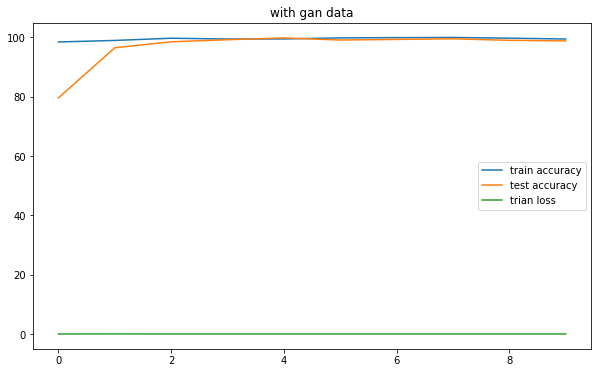

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch [1/10], loss: 0.0004, train accuracy: 97.96%, test accuracy: 99.60%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch [2/10], loss: 0.0000, train accuracy: 99.36%, test accuracy: 99.80%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch [3/10], loss: 0.0005, train accuracy: 99.48%, test accuracy: 99.80%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch [4/10], loss: 0.0088, train accuracy: 99.44%, test accuracy: 98.60%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch [5/10], loss: 0.0000, train accuracy: 99.60%, test accuracy: 99.60%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch [6/10], loss: 0.0003, train accuracy: 99.20%, test accuracy: 99.80%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch [7/10], loss: 0.0005, train accuracy: 99.92%, test accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch [8/10], loss: 0.0602, train accuracy: 99.76%, test accuracy: 99.40%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch [9/10], loss: 0.0000, train accuracy: 99.64%, test accuracy: 99.70%


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch [10/10], loss: 0.0000, train accuracy: 99.78%, test accuracy: 99.70%


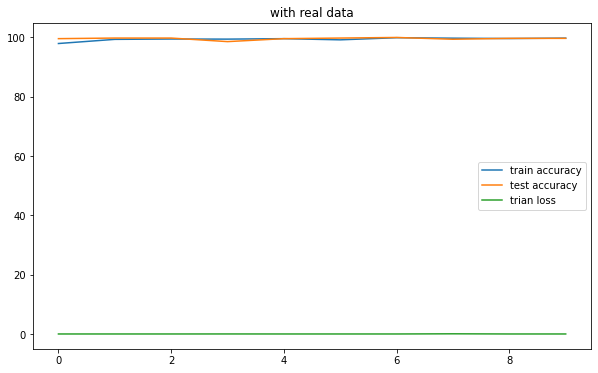

In [15]:
train_losses =[]
tast_accuracy = []
trian_accuracy = []
for epoch in range(epochs):
  train(epoch,train_gan_dataloader,test_dataloader,model1,criterion,optimizer1,"with gan data")
  state = {'epoch':epoch,'model':model1,'optimizer':optimizer1}
  torch.save(state , 'googlenet_gan_data_model')

train_losses =[]
tast_accuracy = []
trian_accuracy = []
for epoch in range(epochs):
  train(epoch,train_real_dataloader,test_dataloader,model2,criterion,optimizer2, "with real data")
  state = {'epoch':epoch,'model':model2,'optimizer':optimizer2}
  torch.save(state , 'googlenet_real_data_model')